# Notebook to evaluate the dependence of colors with atmospheric parameters and to compute color corrections 

In this notebook, we are going to evaluate the dependence of the colors with the atmospheric parameters and the spectral types. We will see if this classification is good or if we should use any alternative. 

# Load necessary packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pysynphot as S
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import chi2
from scipy.integrate import quad
from astropy.io import fits

# allow interactive plots
%matplotlib widget

In [2]:
input_dir = 'output_files/'

Files with atmospheric parameters, colours and errors 

In [3]:
atm_file = 'atm_vals_{0}_airmass_{1}_cloud_{2}.npy'

In [4]:
color_file = 'colour_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}.npy'
color_ref_file = 'colour_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}_ref.npy'

sn_color_file = 'sn_colour_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}.npy'
sn_color_ref_file = 'sn_colour_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}_ref.npy'

In [5]:
color_err_file = 'colour_err_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}.npy'
color_err_ref_file = 'colour_err_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}_ref.npy'

sn_color_err_file = 'sn_colour_err_dict_varying_{0}_airmass_{1:1.1f}_cloud_{2}.npy'
sn_color_err_ref_file = 'sn_colour_err_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}_ref.npy'

In [6]:
spectral_types = ['O','B','A','F','G','K','M']
type_colors = {'O':'violet','B':'cyan','A':'b','F':'g','G':'y','K':'orange','M':'r'}
type_markers = {'O':'s','B':'x','A':'o','F':'v','G':'^','K':'P','M':'*'}

In [7]:
filters = ['u','g','r','i','z','Y']

In [8]:
colors = []
for i in range(len(filters)-1):
    colors.append('{0}-{1}'.format(filters[i].lower(),filters[i+1].lower()))

# Define functions 

In [9]:
def lin_fun(x,a,b):
    return a*x+b

In [10]:
def quad_fun(x,a,b,c):
    return a*x**2.+b*x+c

In [11]:
def quad_dev(x,a,b):
    return 2.*a*x+b

# Atmospheric parameters information 

In [12]:
atm_params = {'pwv':{'min':1.,'max':9.,'fixed':3.0},
               'aerosol':{'min':0.01,'max':0.09,'fixed':0.04},
               'ozone':{'min':200.,'max':400.,'fixed':300},
               'cloud':{'min':0.0,'max':1.0,'fixed':0.0},
               'airmass':{'min':1.0,'max':2.0,'fixed':1.2},
}

In [13]:
min_airmass = atm_params['airmass']['min']
max_airmass = atm_params['airmass']['max']
am_vals = np.round(np.linspace(min_airmass,max_airmass,10),1)
print(am_vals)

[1.  1.1 1.2 1.3 1.4 1.6 1.7 1.8 1.9 2. ]


# Check dependencies 

In [14]:
am0 = atm_params['airmass']['fixed']
cloud0 = atm_params['cloud']['fixed']
pwv0 = atm_params['pwv']['fixed']
aero0 = atm_params['aerosol']['fixed']
oz0 = atm_params['ozone']['fixed']

We evaluate the dependency between $\Delta c^{xy} = c^{xy}_{obs} - c^{xy}_{std}$ and PWV, aerosols and airmass. Each time we vary one parameter, the rest of them are fixed to the standard values. 

For each star of each spectral type we fit $\Delta c^{xy}$ to a function of the given atmospheric parameter, $f(p)$. Then, we compute the mean model for each spectral type as the average of the fitted models on the individual stars. 

# PWV 

In [15]:
pwv_vals = np.load(os.path.join(input_dir,atm_file.format('pwv',am0,cloud0)),allow_pickle=True).ravel()
print(pwv_vals)

[1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [16]:
pwv_color_dict = np.load(os.path.join(input_dir,color_file.format('pwv',am0,cloud0)),allow_pickle=True).ravel()[0]
pwv_color_ref_dict = np.load(os.path.join(input_dir,color_ref_file).format('pwv',am0,cloud0),allow_pickle=True).ravel()[0]

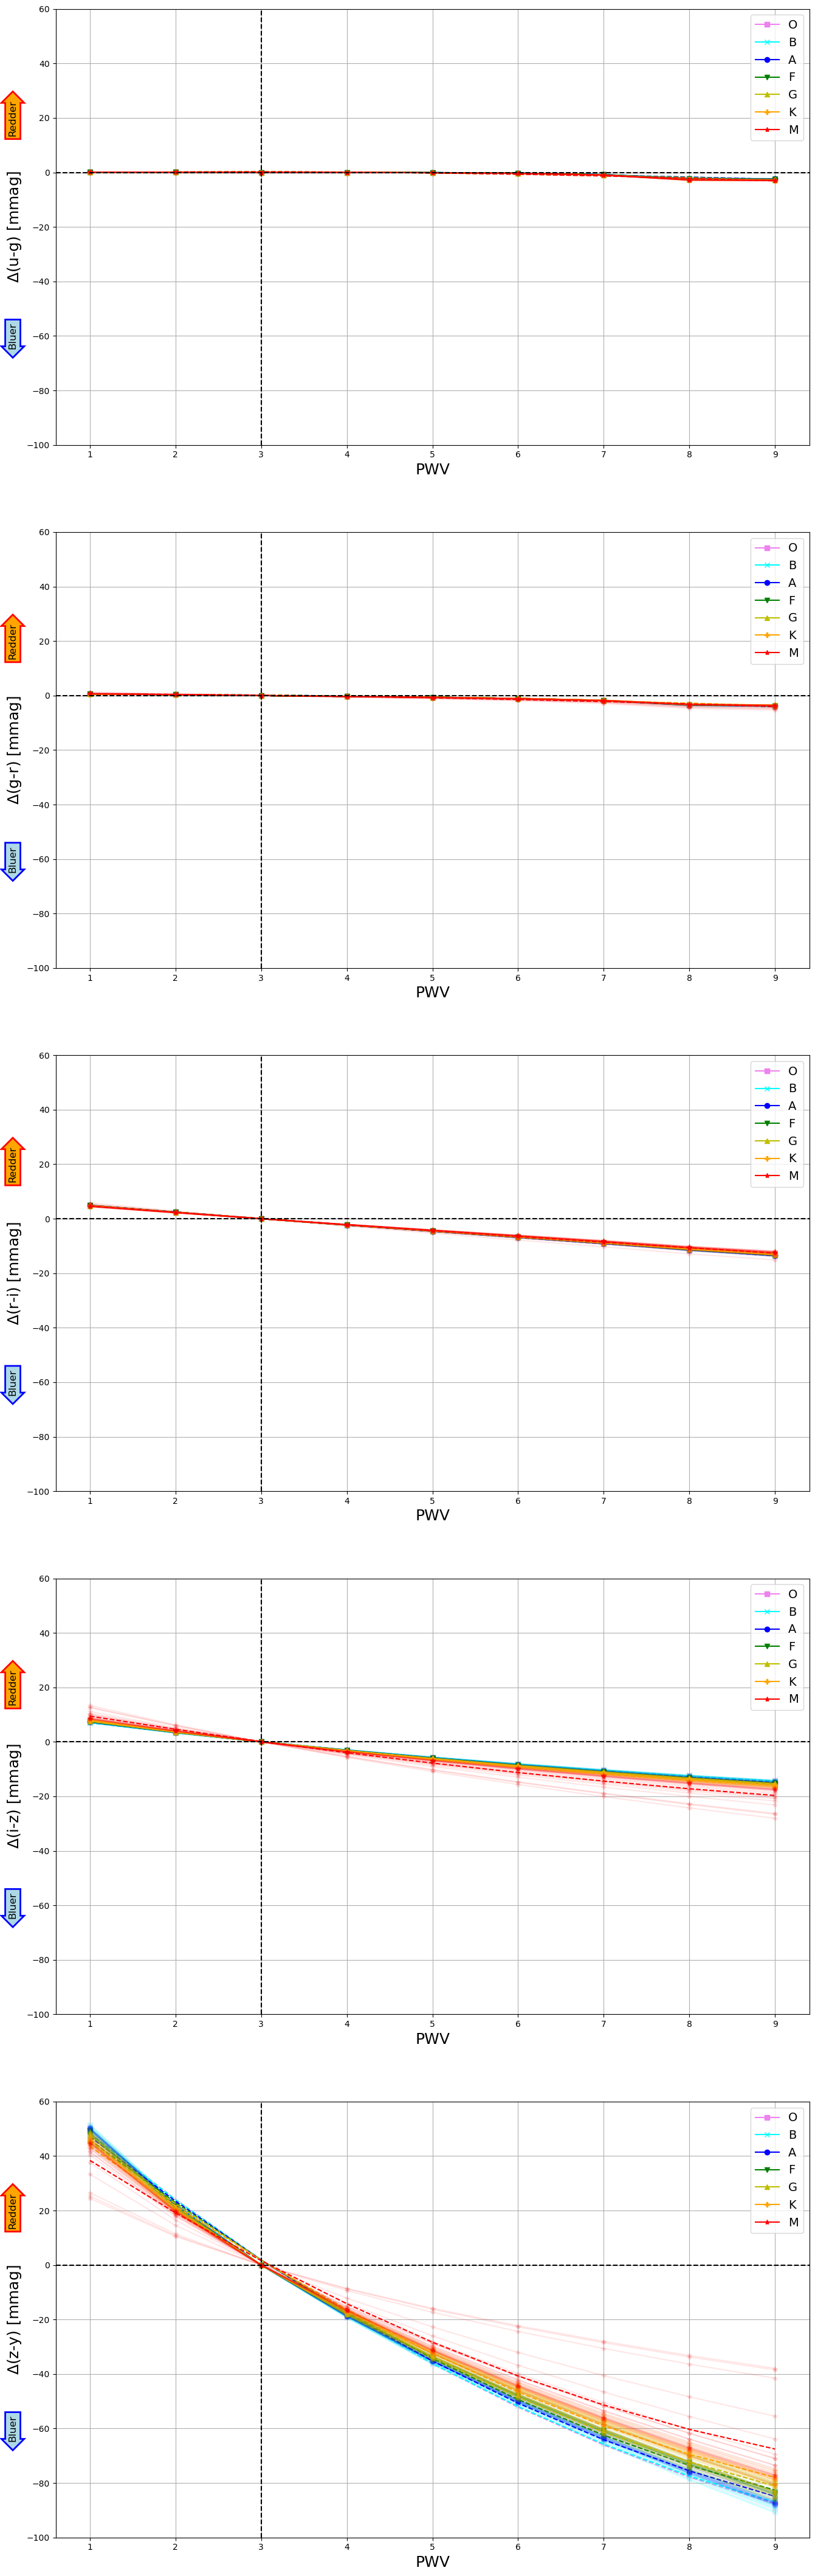

In [17]:
plt.ioff()
fig_rows = len(colors)
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,54))

yrange = (-100.,60.)

pwv_model_dict = {}
for row,color in enumerate(colors):
    for spec_type in spectral_types:
        param_list = []
        for si in pwv_color_dict[spec_type]:
            delta_c_ = (pwv_color_dict[spec_type][si][color]-pwv_color_ref_dict[spec_type][si][color])*1000.
            
            p_,cov_ = curve_fit(quad_fun,pwv_vals,delta_c_/1000.)
            param_list.append(p_)
            
            axs[row].plot(pwv_vals,delta_c_,marker=type_markers[spec_type],c=type_colors[spec_type],alpha=0.1)
        param_list = np.array(param_list)
        mean_params_ = np.mean(param_list,axis=0)
        pwv_model_dict[(spec_type,color)] = mean_params_
        
        model_ = quad_fun(pwv_vals,mean_params_[0],mean_params_[1],mean_params_[2])*1000.
        axs[row].plot(pwv_vals,model_,ls='--',marker='',c=type_colors[spec_type])
        axs[row].plot([],[],marker=type_markers[spec_type],c=type_colors[spec_type],label=spec_type)
    axs[row].axhline(y=0.0,ls='--',color='k')
    axs[row].axvline(x=pwv0,ls='--',color='k')
    axs[row].set_ylim(yrange)
    axs[row].grid()
    axs[row].set_xlabel('PWV',fontsize=18)
    axs[row].set_ylabel(r'$\Delta$'+'('+color+') [mmag]',fontsize=18)
    axs[row].text(0.1,-60.,"Bluer",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="larrow,pad=0.3",fc="lightblue",ec="blue",lw=2))
    axs[row].text(0.1,20.,"Redder",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="rarrow,pad=0.3",fc="orange",ec="red",lw=2))
    axs[row].legend(loc="best",fontsize=14)
            
    
display(fig)

del fig,axs
plt.ion() 

# Aerosols 

In [18]:
aero_vals = np.load(os.path.join(input_dir,atm_file.format('aerosol',am0,cloud0)),allow_pickle=True).ravel()
print(aero_vals)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]


In [19]:
aero_color_dict = np.load(os.path.join(input_dir,color_file.format('aerosol',am0,cloud0)),allow_pickle=True).ravel()[0]
aero_color_ref_dict = np.load(os.path.join(input_dir,color_ref_file).format('aerosol',am0,cloud0),allow_pickle=True).ravel()[0]

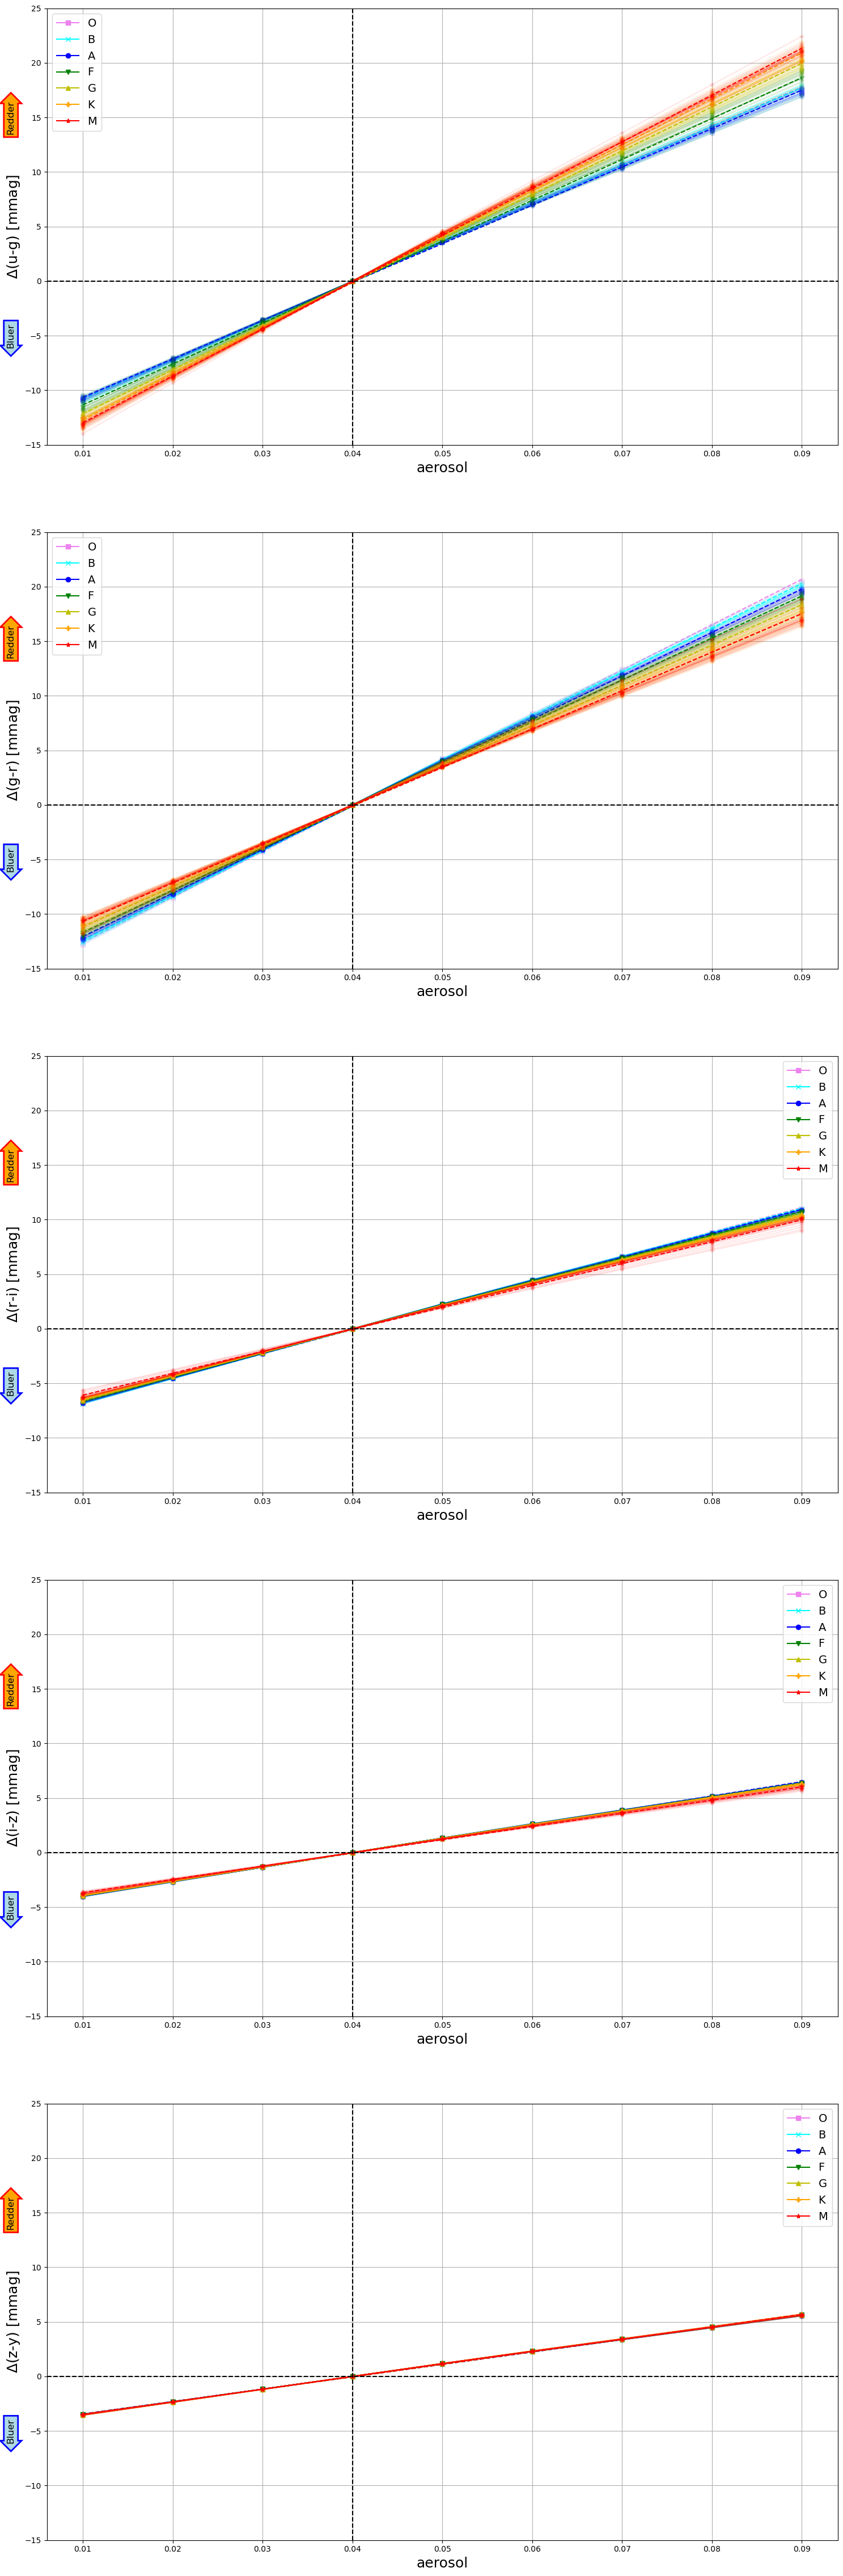

In [20]:
plt.ioff()
fig_rows = len(colors)
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(18,58))

yrange = (-15.,25.)

aero_model_dict = {}
for row,color in enumerate(colors):
    for spec_type in spectral_types:
        param_list = []
        for si in aero_color_dict[spec_type]:
            delta_c_ = (aero_color_dict[spec_type][si][color]-aero_color_ref_dict[spec_type][si][color])*1000.
            
            p_,cov_ = curve_fit(lin_fun,aero_vals,delta_c_/1000.)
            param_list.append(p_)
            
            axs[row].plot(aero_vals,delta_c_,marker=type_markers[spec_type],c=type_colors[spec_type],alpha=0.1)
            
        param_list = np.array(param_list)
        mean_params_ = np.mean(param_list,axis=0)
        aero_model_dict[(spec_type,color)] = mean_params_
        
        model_ = lin_fun(aero_vals,mean_params_[0],mean_params_[1])*1000.
        axs[row].plot(aero_vals,model_,ls='--',marker='',c=type_colors[spec_type])
        axs[row].plot([],[],marker=type_markers[spec_type],c=type_colors[spec_type],label=spec_type)
    axs[row].axhline(y=0.0,ls='--',color='k')
    axs[row].axvline(x=aero0,ls='--',color='k')
    axs[row].set_ylim(yrange)
    axs[row].grid()
    axs[row].set_xlabel('aerosol',fontsize=18)
    axs[row].set_ylabel(r'$\Delta$'+'('+color+') [mmag]',fontsize=18)
    axs[row].text(0.002,-5.,"Bluer",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="larrow,pad=0.3",fc="lightblue",ec="blue",lw=2))
    axs[row].text(0.002,15.,"Redder",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="rarrow,pad=0.3",fc="orange",ec="red",lw=2))
    axs[row].legend(loc="best",fontsize=14)
            
    
display(fig)

del fig,axs
plt.ion() 

# Airmass 

In [21]:
ref_param = 'pwv'
am_color_ref_dict = pwv_color_ref_dict

In [22]:
am_color_dict = {}

for spec_type in spectral_types:
    st_dict_ = {}
    for si in am_color_ref_dict[spec_type]:
        si_dict_ = {}
        for color in colors:
            vals_ = []
            for am in am_vals:
                c_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(ref_param,am,cloud0),allow_pickle=True).ravel()[0]
                vals_.append(c_dict_[spec_type][si][color])
            vals_ = np.array(vals_)
            si_dict_[color] = vals_
        st_dict_[si] = si_dict_
    am_color_dict[spec_type] = st_dict_
        
        

In [23]:
am_color_dict['O'][0]['u-g']-am_color_ref_dict['O'][0]['u-g']

array([-0.05523139, -0.02757394,  0.        ,  0.02749149,  0.05490156,
        0.10948122,  0.1366528 ,  0.16374687,  0.19076444,  0.21764706])

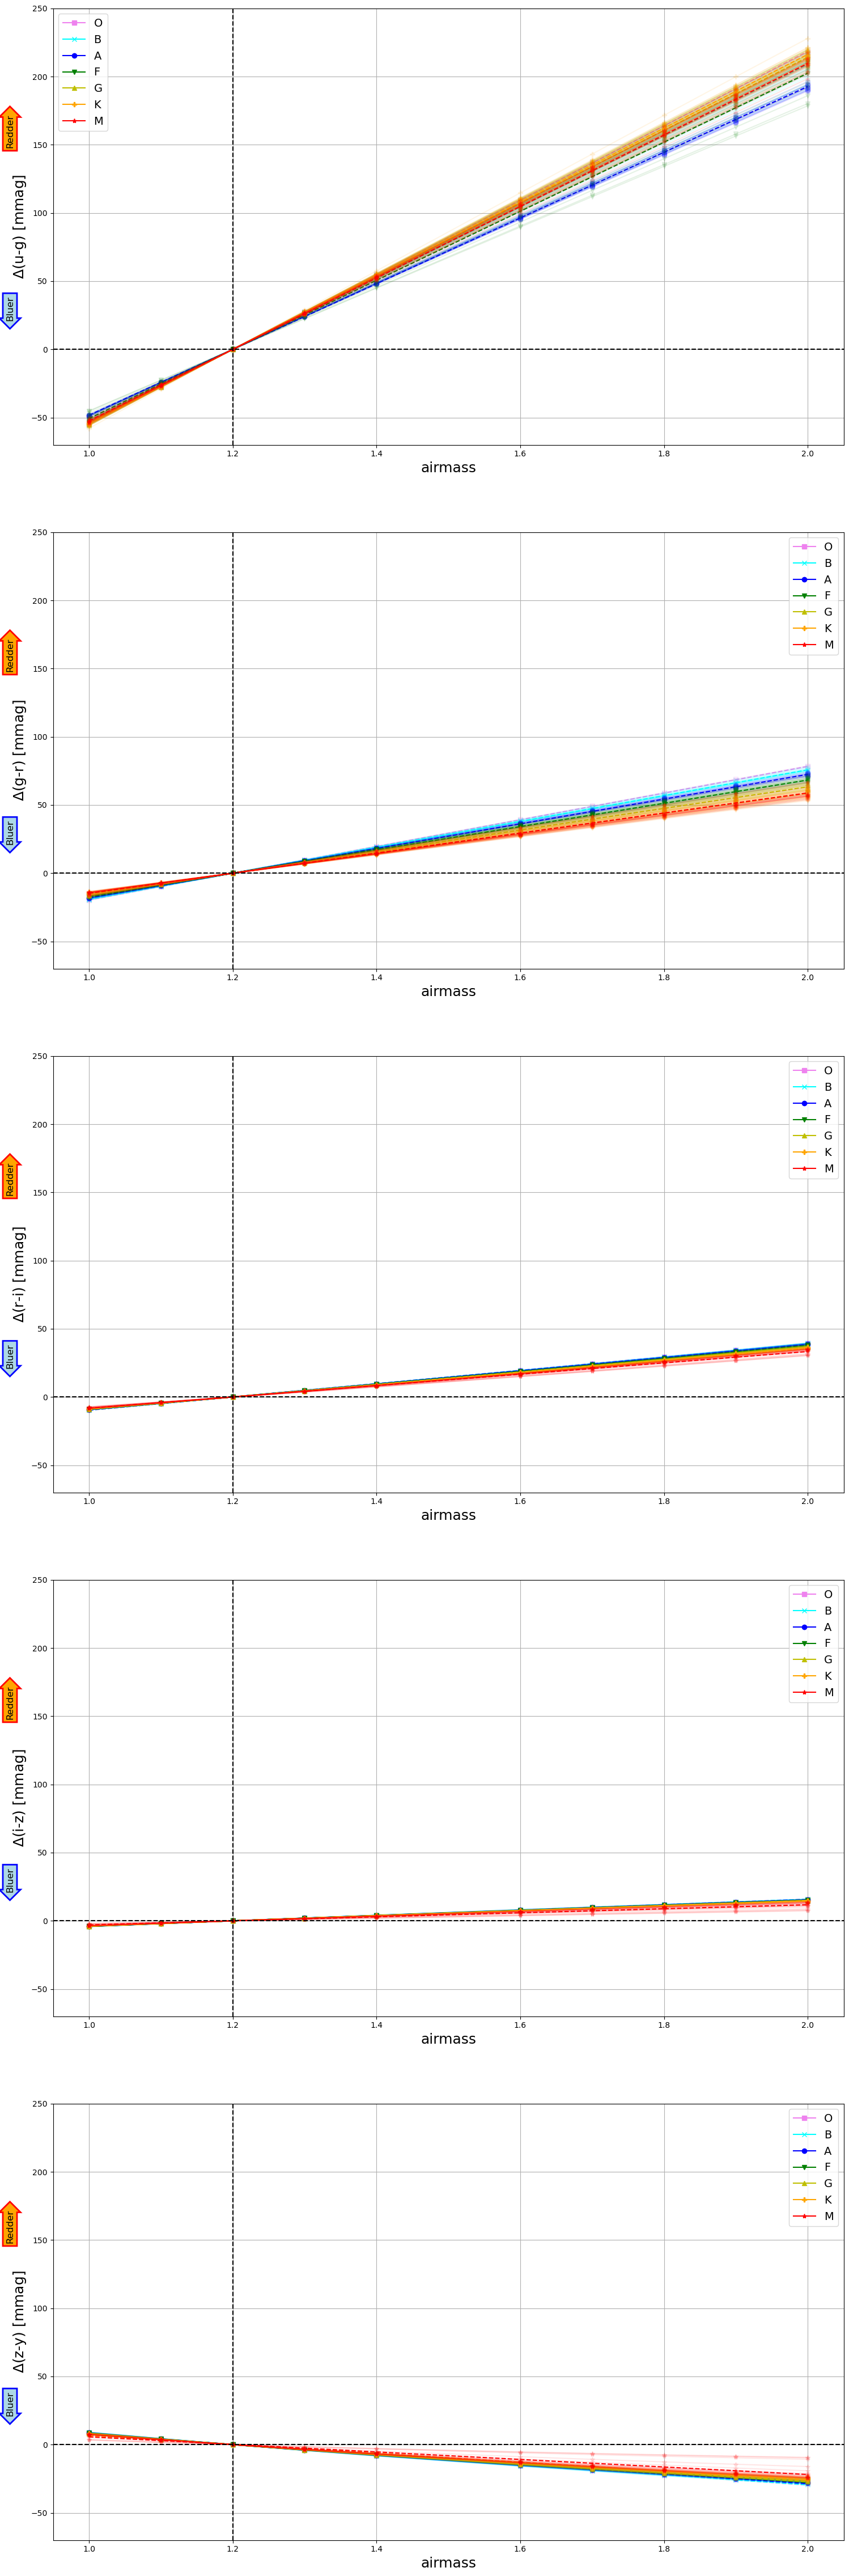

In [43]:
plt.ioff()
fig_rows = len(colors)
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(18,58))

yrange = (-70.,250.)

am_model_dict = {}
for row,color in enumerate(colors):
    for spec_type in spectral_types:
        param_list = []
        for si in am_color_dict[spec_type]:
            delta_c_ = (am_color_dict[spec_type][si][color]-am_color_ref_dict[spec_type][si][color])*1000.
            
            p_,cov_ = curve_fit(lin_fun,am_vals,delta_c_/1000.)
            param_list.append(p_)
            
            axs[row].plot(am_vals,delta_c_,marker=type_markers[spec_type],c=type_colors[spec_type],alpha=0.1)
            
        param_list = np.array(param_list)
        mean_params_ = np.mean(param_list,axis=0)
        am_model_dict[(spec_type,color)] = mean_params_
        
        model_ = lin_fun(am_vals,mean_params_[0],mean_params_[1])*1000.
        axs[row].plot(am_vals,model_,ls='--',marker='',c=type_colors[spec_type])
        axs[row].plot([],[],marker=type_markers[spec_type],c=type_colors[spec_type],label=spec_type)
    axs[row].axhline(y=0.0,ls='--',color='k')
    axs[row].axvline(x=am0,ls='--',color='k')
    axs[row].set_ylim(yrange)
    axs[row].grid()
    axs[row].set_xlabel('airmass',fontsize=18)
    axs[row].set_ylabel(r'$\Delta$'+'('+color+') [mmag]',fontsize=18)
    axs[row].text(0.89,30.,"Bluer",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="larrow,pad=0.3",fc="lightblue",ec="blue",lw=2))
    axs[row].text(0.89,160.,"Redder",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="rarrow,pad=0.3",fc="orange",ec="red",lw=2))
    axs[row].legend(loc="best",fontsize=14)
            
    
display(fig)

del fig,axs
plt.ion() 

# 3D visualization 

For PWV we focus on the reddest colors 

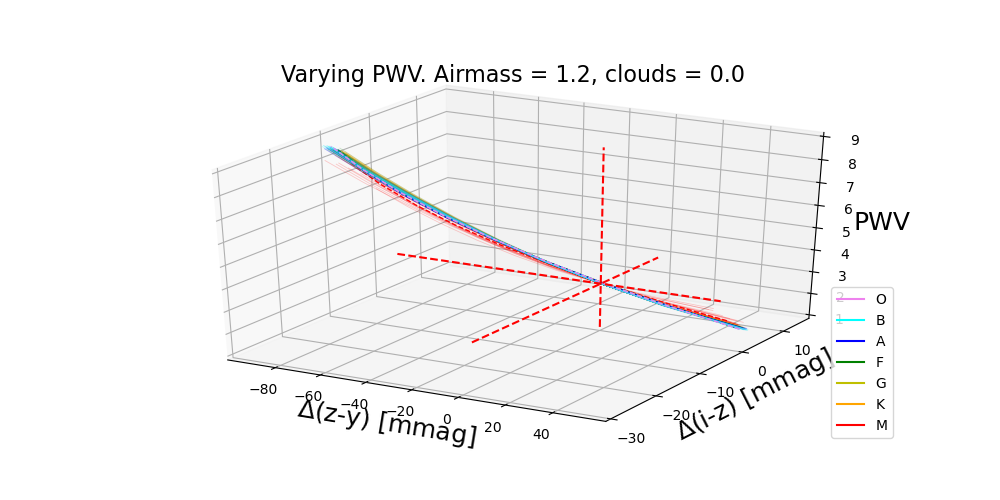

In [25]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

cy = 'i-z'
cx = 'z-y'
        
iso_vals1 = []
iso_vals2 = []
for spec_type in spectral_types[::-1]:
    for si in pwv_color_dict[spec_type]:
        delta1 = (pwv_color_dict[spec_type][si][cx.lower()]-pwv_color_ref_dict[spec_type][si][cx.lower()])*1000.
        delta2 = (pwv_color_dict[spec_type][si][cy.lower()]-pwv_color_ref_dict[spec_type][si][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)
        
        iso_vals1.append(delta1)
        iso_vals2.append(delta2)
        
        #ax.scatter(delta1,delta2,pwv_vals,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
        ax.plot(delta1,delta2,pwv_vals,ls='-',linewidth=0.6,marker='',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = pwv_model_dict[(spec_type,cx.lower())]
    params2 = pwv_model_dict[(spec_type,cy.lower())]
    model1 = quad_fun(pwv_vals,params1[0],params1[1],params1[2])*1000.
    model2 = quad_fun(pwv_vals,params2[0],params2[1],params2[2])*1000.
    ax.plot(model1,model2,pwv_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
            
'''
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
        delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
        axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
        axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
        axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')


iso_vals1 = np.array(iso_vals1)
iso_vals2 = np.array(iso_vals2)
for val in range(iso_vals1.shape[1]):
    #print(iso_vals1[:,val])
    sort_index = np.argsort(iso_vals1[:,val])
    ax.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
'''    

xrange = np.linspace(np.min(iso_vals1),np.max(iso_vals1),100)
yrange = np.linspace(np.min(iso_vals2),np.max(iso_vals2),100)
zrange = np.linspace(np.min(pwv_vals),np.max(pwv_vals),100)

ax.plot(xrange,np.zeros(len(yrange)),np.ones(len(zrange))*pwv0,'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.ones(len(zrange))*pwv0,'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('PWV',fontsize=18)
ax.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format('PWV',am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


For aerosols we focus on the bluest colors 

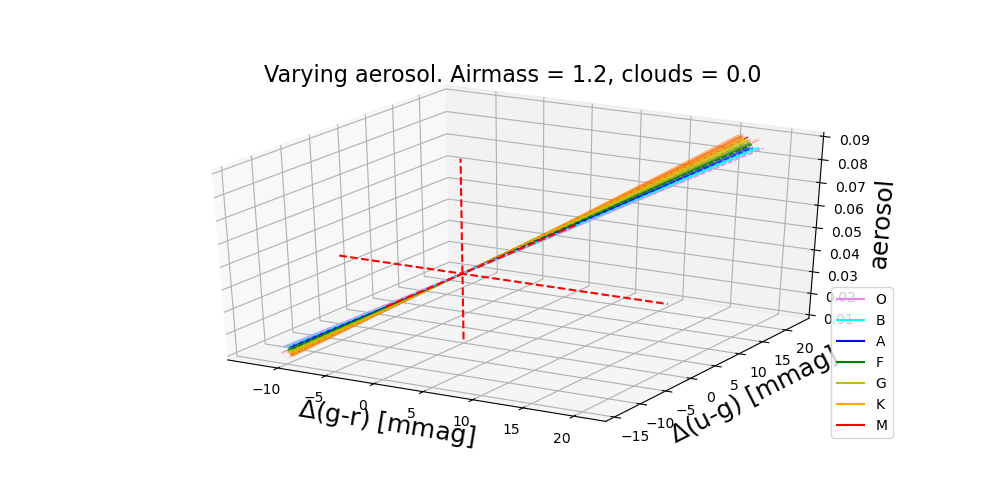

In [26]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

cy = 'u-g'
cx = 'g-r'
        
iso_vals1 = []
iso_vals2 = []
for spec_type in spectral_types[::-1]:
    for si in aero_color_dict[spec_type]:
        delta1 = (aero_color_dict[spec_type][si][cx.lower()]-aero_color_ref_dict[spec_type][si][cx.lower()])*1000.
        delta2 = (aero_color_dict[spec_type][si][cy.lower()]-aero_color_ref_dict[spec_type][si][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)
        
        iso_vals1.append(delta1)
        iso_vals2.append(delta2)
        
        #ax.scatter(delta1,delta2,pwv_vals,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
        ax.plot(delta1,delta2,aero_vals,ls='-',linewidth=0.6,marker='',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = aero_model_dict[(spec_type,cx.lower())]
    params2 = aero_model_dict[(spec_type,cy.lower())]
    model1 = lin_fun(aero_vals,params1[0],params1[1])*1000.
    model2 = lin_fun(aero_vals,params2[0],params2[1])*1000.
    ax.plot(model1,model2,aero_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
        
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
            
'''
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
        delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
        axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
        axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
        axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')


iso_vals1 = np.array(iso_vals1)
iso_vals2 = np.array(iso_vals2)
for val in range(iso_vals1.shape[1]):
    #print(iso_vals1[:,val])
    sort_index = np.argsort(iso_vals1[:,val])
    ax.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
'''    

xrange = np.linspace(np.min(iso_vals1),np.max(iso_vals1),100)
yrange = np.linspace(np.min(iso_vals2),np.max(iso_vals2),100)
zrange = np.linspace(np.min(aero_vals),np.max(aero_vals),100)

ax.plot(xrange,np.zeros(len(yrange)),np.ones(len(zrange))*aero0,'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.ones(len(zrange))*aero0,'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('aerosol',fontsize=18)
ax.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format('aerosol',am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


Airmass has its most important impact at the bluest colors, but it has a wide impact 

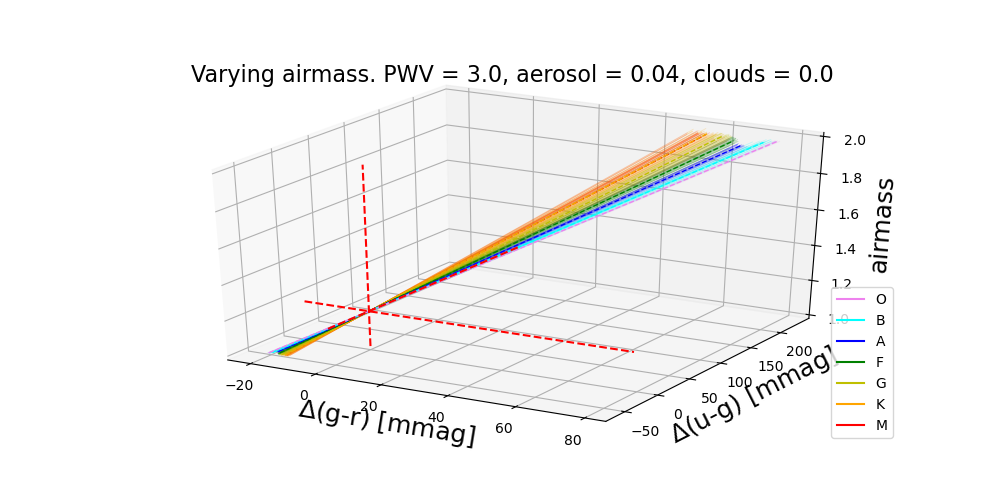

In [27]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

cy = 'u-g'
cx = 'g-r'
        
iso_vals1 = []
iso_vals2 = []
for spec_type in spectral_types[::-1]:
    for si in am_color_dict[spec_type]:
        delta1 = (am_color_dict[spec_type][si][cx.lower()]-am_color_ref_dict[spec_type][si][cx.lower()])*1000.
        delta2 = (am_color_dict[spec_type][si][cy.lower()]-am_color_ref_dict[spec_type][si][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)
        
        iso_vals1.append(delta1)
        iso_vals2.append(delta2)
        
        #ax.scatter(delta1,delta2,pwv_vals,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
        ax.plot(delta1,delta2,am_vals,ls='-',linewidth=0.6,marker='',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = am_model_dict[(spec_type,cx.lower())]
    params2 = am_model_dict[(spec_type,cy.lower())]
    model1 = lin_fun(am_vals,params1[0],params1[1])*1000.
    model2 = lin_fun(am_vals,params2[0],params2[1])*1000.
    ax.plot(model1,model2,am_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
            
'''
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
        delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
        axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
        axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
        axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')


iso_vals1 = np.array(iso_vals1)
iso_vals2 = np.array(iso_vals2)
for val in range(iso_vals1.shape[1]):
    #print(iso_vals1[:,val])
    sort_index = np.argsort(iso_vals1[:,val])
    ax.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
'''    

xrange = np.linspace(np.min(iso_vals1),np.max(iso_vals1),100)
yrange = np.linspace(np.min(iso_vals2),np.max(iso_vals2),100)
zrange = np.linspace(np.min(am_vals),np.max(am_vals),100)

ax.plot(xrange,np.zeros(len(yrange)),np.ones(len(zrange))*am0,'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.ones(len(zrange))*am0,'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('airmass',fontsize=18)
ax.set_title('Varying {0}. PWV = {1}, aerosol = {2}, clouds = {3}'.format('airmass',pwv0,aero0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


# Evaluate model and calculate correction 

The quantity we are working with is $\Delta \vec{c} = \vec{c}_{obs} - \vec{c}_{std}$, with $\vec{c}_{std}$ the colors observed in a standard atmosphere. Then, for each component of the color vector we have that the variation with an atmospheric parameter, $p$, is given by 

$$\frac{\partial c^{xy}}{\partial p} = \frac{\Delta c^{xy}}{\Delta p} = v^{xy} \, .$$ 

Each component of the vector $\vec{v}$ corresponds to the derivative with respect to $p$ of the fitted functions, $f^{\prime \, xy}(p)$. 

Let's have a look at the trajectory in the $\Delta c$ - PWV plane of an M-type star 

In [28]:
test_types = ['M']
test_specs = [0]

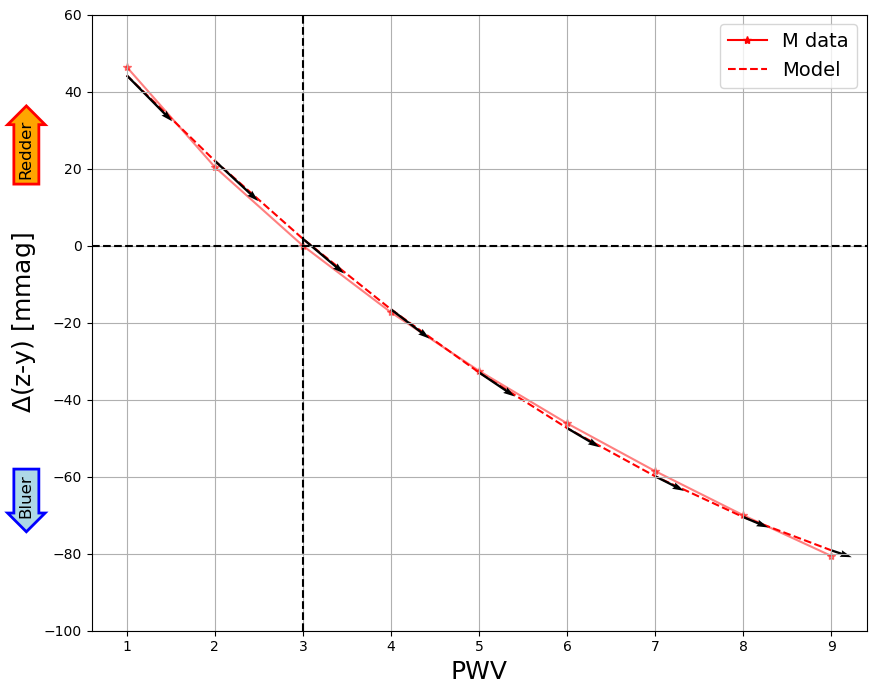

In [29]:
test_color = ['z-y']

plt.ioff()
fig_rows = 1
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(10,8))

yrange = (-100.,60.)

for row,color in enumerate(test_color):
    for spec_type in test_types:
        param_list = []
        for si in test_specs:
            delta_c_ = (pwv_color_dict[spec_type][si][color]-pwv_color_ref_dict[spec_type][si][color])*1000.
            
            p_,cov_ = curve_fit(quad_fun,pwv_vals,delta_c_/1000.)
            param_list.append(p_)
            
            axs.plot(pwv_vals,delta_c_,marker=type_markers[spec_type],c=type_colors[spec_type],alpha=0.5,zorder=-1)
            
        axs.plot([],[],marker=type_markers[spec_type],c=type_colors[spec_type],label=spec_type+' data')
        
        param_list = np.array(param_list)
        mean_params_ = np.mean(param_list,axis=0)
        
        model_ = quad_fun(pwv_vals,mean_params_[0],mean_params_[1],mean_params_[2])*1000.
        axs.plot(pwv_vals,model_,ls='--',marker='',c=type_colors[spec_type],label='Model',zorder=-1)
        
        dev_ = quad_dev(pwv_vals,mean_params_[0],mean_params_[1])*1000.
    
        #axs.quiver(pwv_vals,delta_c_,np.ones(len(pwv_vals)),dev_,color='k',angles='xy',width=0.003)
        axs.quiver(pwv_vals,model_,np.ones(len(pwv_vals)),dev_,color='k',angles='xy',width=0.003,zorder=1)
        
    axs.axhline(y=0.0,ls='--',color='k')
    axs.axvline(x=pwv0,ls='--',color='k')
    axs.set_ylim(yrange)
    axs.grid()
    axs.text(-0.14,-65.,"Bluer",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="larrow,pad=0.3",fc="lightblue",ec="blue",lw=2))
    axs.text(-0.14,25.,"Redder",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="rarrow,pad=0.3",fc="orange",ec="red",lw=2))
    axs.set_xlabel('PWV',fontsize=18)
    axs.set_ylabel(r'$\Delta$'+'('+color+') [mmag]',fontsize=18)
    axs.legend(loc="best",fontsize=14)
            
    
display(fig)

del fig,axs
plt.ion() 

3D view of the trajectories 

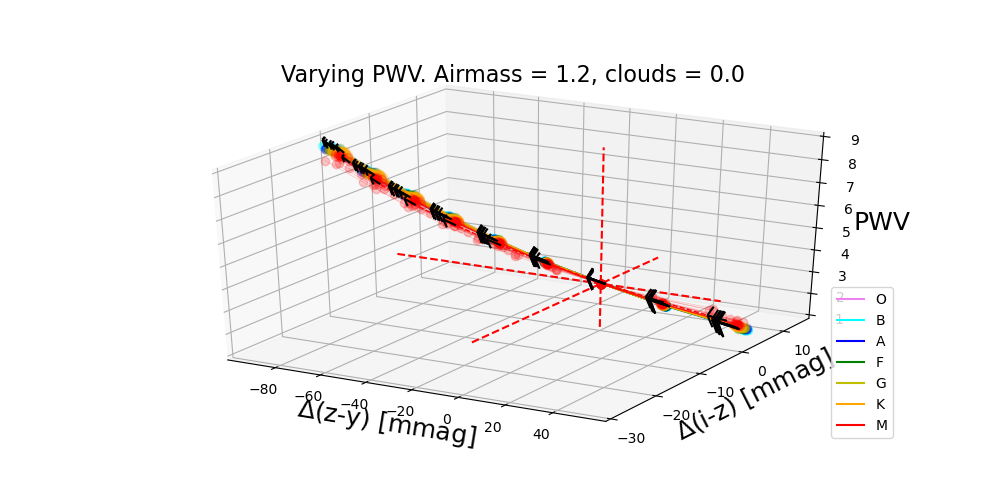

In [30]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

cy = 'i-z'
cx = 'z-y'
        
iso_vals1 = []
iso_vals2 = []
for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        delta1 = (pwv_color_dict[spec_type][si][cx.lower()]-pwv_color_ref_dict[spec_type][si][cx.lower()])*1000.
        delta2 = (pwv_color_dict[spec_type][si][cy.lower()]-pwv_color_ref_dict[spec_type][si][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)
        
        iso_vals1.append(delta1)
        iso_vals2.append(delta2)
        
        #ax.scatter(delta1,delta2,pwv_vals,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
        ax.plot(delta1,delta2,pwv_vals,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = pwv_model_dict[(spec_type,cx.lower())]
    params2 = pwv_model_dict[(spec_type,cy.lower())]
    model1 = quad_fun(pwv_vals,params1[0],params1[1],params1[2])*1000.
    model2 = quad_fun(pwv_vals,params2[0],params2[1],params2[2])*1000.
    ax.plot(model1,model2,pwv_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
    
    dev1 = quad_dev(pwv_vals,params1[0],params1[1])*1000.
    dev2 = quad_dev(pwv_vals,params2[0],params2[1])*1000.
    
    
    #ax.quiver(delta1,delta2,pwv_vals,dev1,dev2,np.ones(len(delta1)),color='k',length=0.3,normalize=False)
    ax.quiver(model1,model2,pwv_vals,dev1,dev2,np.ones(len(delta1)),color='k',length=0.3,normalize=False)
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

xrange = np.linspace(np.min(iso_vals1),np.max(iso_vals1),100)
yrange = np.linspace(np.min(iso_vals2),np.max(iso_vals2),100)
zrange = np.linspace(np.min(pwv_vals),np.max(pwv_vals),100)

ax.plot(xrange,np.zeros(len(yrange)),np.ones(len(zrange))*pwv0,'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.ones(len(zrange))*pwv0,'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('PWV',fontsize=18)
ax.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format('PWV',am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


Now we compute the corrections for each color, $c^{xy}$: 
$$c^{xy}_{corr} = c^{xy}_{obs} - \int_{p_{std}}^{p_{obs}} f^{\prime \, xy}(p) dp \, ,$$ 
where 
$$f^{\prime \, xy}(p) = \frac{\partial c^{xy}}{\partial p} = \frac{\partial \Delta c^{xy}}{\partial p} \, . $$ 
Then, the color corrections are given by the primitive of $f^{\prime \, xy}$, which are just but the $f^{xy}(p)$ functions that we fitted above for each color change. 

In [31]:
pwv_corr_dict = {}
for color in colors:
    for spec_type in spectral_types:
        
        params_ = pwv_model_dict[(spec_type,color.lower())]
        def df_(x):
            return quad_dev(x,params_[0],params_[1])
        
        correction = []
        for p in pwv_vals:
            correction_ = quad(df_,pwv0,p)[0]
            correction.append(correction_)
        correction = np.array(correction)
        #correction2 = np.trapz(df_(pwv_vals),pwv_vals)
        pwv_corr_dict[(spec_type,color)] = correction
        
    

# Evaluate the color corrections 

Let's focus on the PWV corrections: 

In [32]:
pwv_colors = ['r-i','i-z','z-Y']

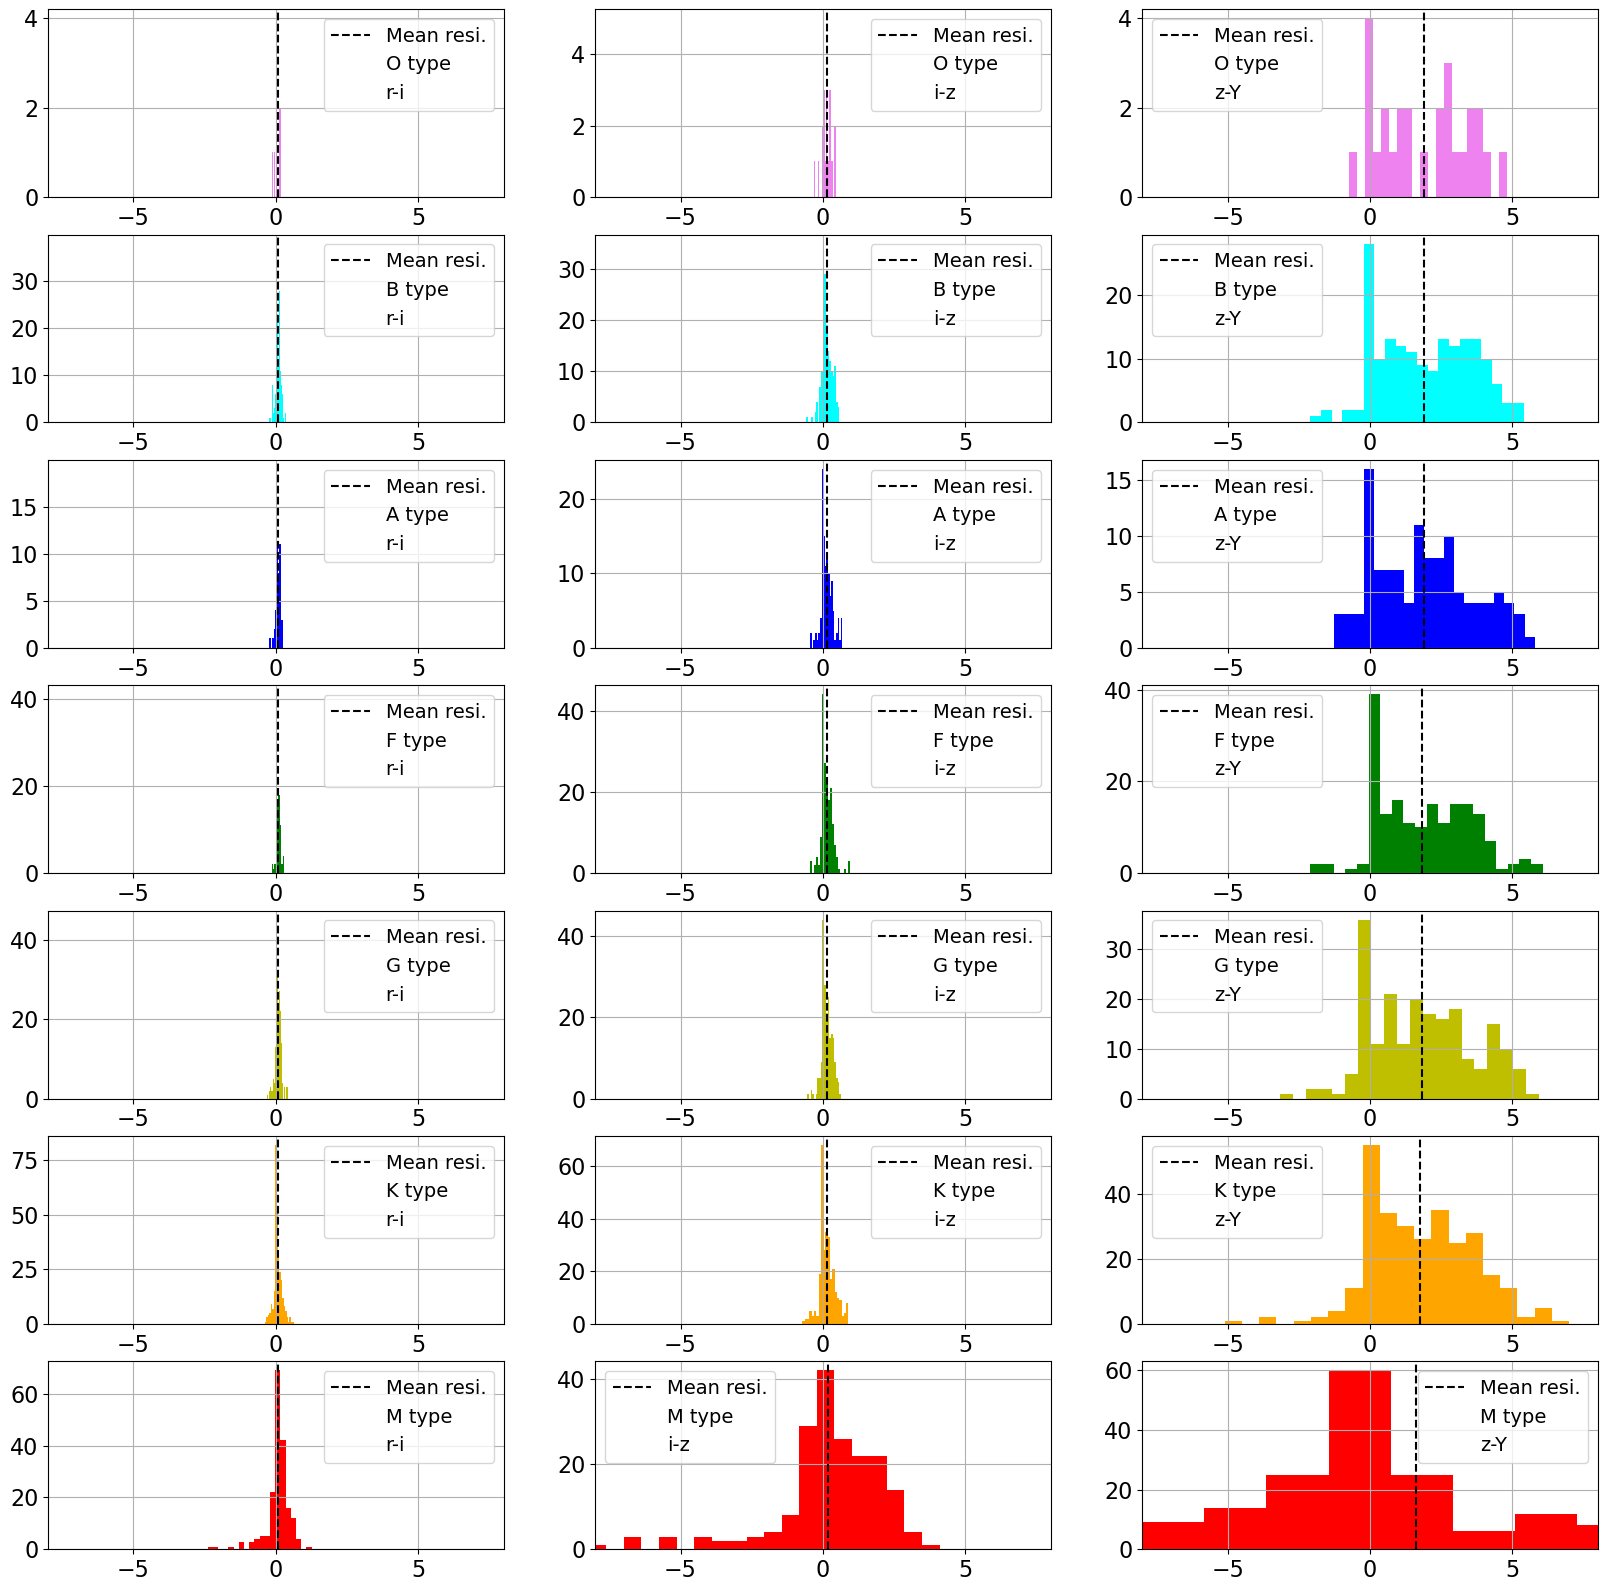

In [33]:
plt.ioff()

fig_rows = len(spectral_types)
fig_cols = len(pwv_colors)

rangex2 = (-250.,-70.)
rangey2 = (-130.,-100.)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,20))

for row in range(fig_rows):
    st_ = spectral_types[row]
    
    for col in range(fig_cols):
        c_ = pwv_colors[col]
        corr_ = pwv_corr_dict[(st_,c_.lower())]*1000.
        
        residual_ = []
        for si in pwv_color_dict[st_]:
            c_obs_ = np.array(pwv_color_dict[st_][si][c_.lower()]*1000.)
            
            c_ref_ = pwv_color_ref_dict[st_][si][c_.lower()]*1000.
                
            c_corr_ = np.array(c_obs_-corr_)
            resi_ = c_corr_-c_ref_
            
            residual_.append(resi_)
            
        residual_ = np.array(residual_).flatten()
        mean_residual_ = np.mean(residual_)
        
        axs[row,col].hist(residual_,bins=20,color=type_colors[st_])
        axs[row,col].axvline(x=mean_residual_,ls='--',c='k',label='Mean resi.')
        axs[row,col].plot([],[],ls='',marker='',label='{0} type'.format(st_))
        axs[row,col].plot([],[],ls='',marker='',label='{0}'.format(c_))
        axs[row,col].grid()
        axs[row,col].tick_params(axis='x', labelsize=16)
        axs[row,col].tick_params(axis='y', labelsize=16)
        axs[row,col].set_xlim(-8.,8.)
        axs[row,col].legend(loc="best",fontsize=14)

        
display(fig)

del fig,axs
plt.ion() 

In [49]:
test_type = 'M'
test_spec = 0

In [50]:
pwv1 = np.min(pwv_vals)
pwv2 = np.max(pwv_vals)
index1 = np.where(pwv_vals==pwv1)[0][0]
index2 = np.where(pwv_vals==pwv2)[0][0]
indices = np.array([index1,index2])

/tmp/ipykernel_270914/2790125288.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 1, figsize=(12,6))


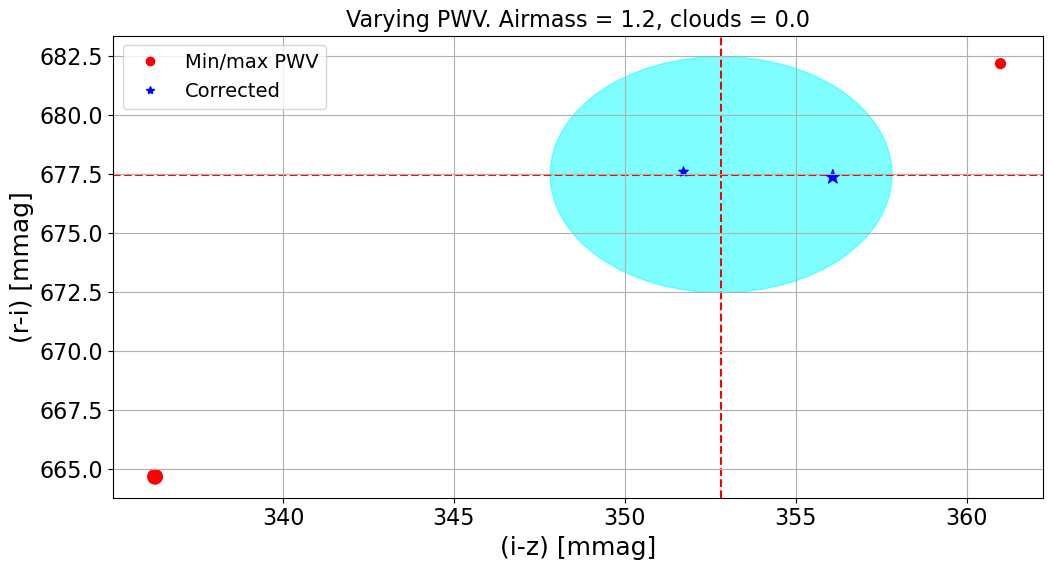

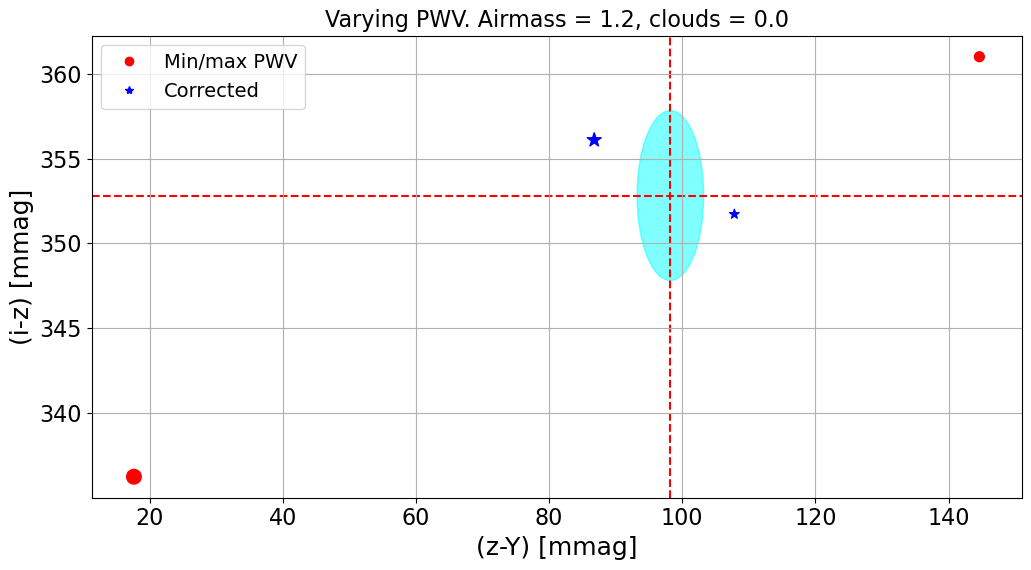

In [51]:
plt.ioff()

fig_rows = len(pwv_colors)-1

rangex2 = (-250.,-70.)
rangey2 = (-130.,-100.)

i = 0
for row in range(fig_rows):
    if i<len(filters)-2:
        fig, axs = plt.subplots(1, 1, figsize=(12,6))
        cy = pwv_colors[i]
        cx = pwv_colors[i+1]
        
        corr1 = pwv_corr_dict[(test_type,cx.lower())][indices]*1000.
        corr2 = pwv_corr_dict[(test_type,cy.lower())][indices]*1000.
            
        c1_obs = pwv_color_dict[test_type][test_spec][cx.lower()][indices]*1000.
        c2_obs = pwv_color_dict[test_type][test_spec][cy.lower()][indices]*1000.
        
        c1_ref = pwv_color_ref_dict[test_type][test_spec][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[test_type][test_spec][cy.lower()]*1000.
        
        c1_corr = c1_obs-corr1
        c2_corr = c2_obs-corr2
        
        msize = [50.,110.]
        
        axs.scatter(c1_obs,c2_obs,c='r',marker='o',s=msize,alpha=1.0,zorder=1)
        axs.scatter(c1_corr,c2_corr,c='b',marker='*',s=msize,alpha=1.0,zorder=1)
        axs.axvline(x=c1_ref,ls='--',color='r',zorder=-1)
        axs.axhline(y=c2_ref,ls='--',color='r',zorder=-1)
        circle = plt.Circle((c1_ref, c2_ref), 5., color='cyan', fill=True, alpha=0.5, zorder=-1)
        axs.add_patch(circle)
                
        axs.plot([],[],c='r',ls='',marker='o',label='Min/max PWV')
        axs.plot([],[],c='b',ls='',marker='*',label='Corrected')
            
        axs.grid()
        axs.tick_params(axis='x', labelsize=16)
        axs.tick_params(axis='y', labelsize=16)
        #axs.set_xlim(rangex2)
        #axs.set_ylim(rangey2)
        #axs.set_aspect('equal')
        
        axs.set_xlabel('('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel('('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format('PWV',am0,cloud0),fontsize=16)
        axs.legend(loc="upper left",fontsize=14)
        i += 1
        
    display(fig)

del fig,axs
plt.ion() 

# Now we make a color-color diagram of all stellar types together 

First, let's have a look at the trajectory of the colors (not $\Delta c$) as a function of the atmospheric parameters 

PWV 

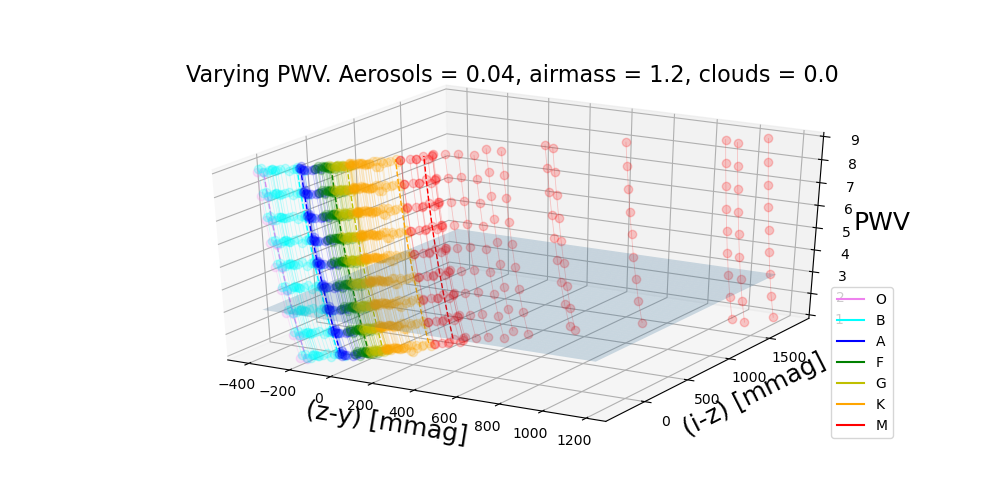

In [37]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

cy = 'i-z'
cx = 'z-y'

minc1 = []
maxc1 = []
minc2 = []
maxc2 = []
for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1 = pwv_color_dict[spec_type][si][cx.lower()]*1000.
        c2 = pwv_color_dict[spec_type][si][cy.lower()]*1000.
        
        c1_ref = pwv_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[spec_type][si][cy.lower()]*1000.
        
        minc1.append(np.min(c1))
        maxc1.append(np.max(c1))
        minc2.append(np.min(c2))
        maxc2.append(np.max(c2))
        
        ax.plot(c1,c2,pwv_vals,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = pwv_model_dict[(spec_type,cx.lower())]
    params2 = pwv_model_dict[(spec_type,cy.lower())]
    model1 = quad_fun(pwv_vals,params1[0],params1[1],params1[2])*1000.
    model2 = quad_fun(pwv_vals,params2[0],params2[1],params2[2])*1000.
    ax.plot(model1+c1_ref,model2+c2_ref,pwv_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
    
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

X, Y = np.meshgrid(np.linspace(np.min(minc1),np.max(maxc1),100), np.linspace(np.min(minc2),np.max(maxc2),100))
Z = np.ones(X.shape)*pwv0
ax.plot_surface(X, Y, Z, alpha=0.2)

ax.grid()  
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('PWV',fontsize=18)
ax.set_title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format('PWV',aero0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


Aerosols 

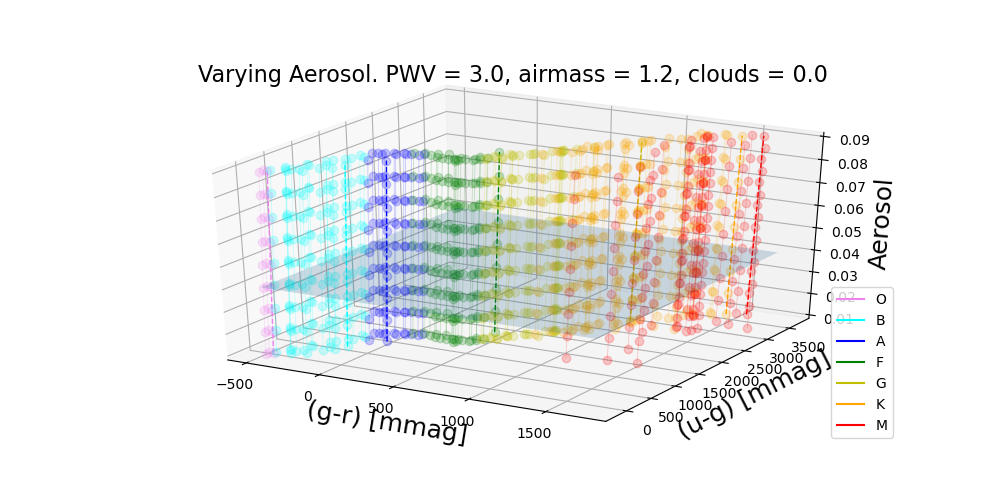

In [38]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

cy = 'u-g'
cx = 'g-r'

minc1 = []
maxc1 = []
minc2 = []
maxc2 = []
for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1 = aero_color_dict[spec_type][si][cx.lower()]*1000.
        c2 = aero_color_dict[spec_type][si][cy.lower()]*1000.
        
        c1_ref = aero_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = aero_color_ref_dict[spec_type][si][cy.lower()]*1000.
        
        minc1.append(np.min(c1))
        maxc1.append(np.max(c1))
        minc2.append(np.min(c2))
        maxc2.append(np.max(c2))
        
        #ax.scatter(c1,c2,pwv_vals,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
        ax.plot(c1,c2,aero_vals,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = aero_model_dict[(spec_type,cx.lower())]
    params2 = aero_model_dict[(spec_type,cy.lower())]
    model1 = lin_fun(aero_vals,params1[0],params1[1])*1000.
    model2 = lin_fun(aero_vals,params2[0],params2[1])*1000.
    ax.plot(model1+c1_ref,model2+c2_ref,aero_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
    
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

X, Y = np.meshgrid(np.linspace(np.min(minc1),np.max(maxc1),100), np.linspace(np.min(minc2),np.max(maxc2),100))
Z = np.ones(X.shape)*aero0
ax.plot_surface(X, Y, Z, alpha=0.2)

ax.grid()
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('Aerosol',fontsize=18)
ax.set_title('Varying {0}. PWV = {1}, airmass = {2}, clouds = {3}'.format('Aerosol',pwv0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


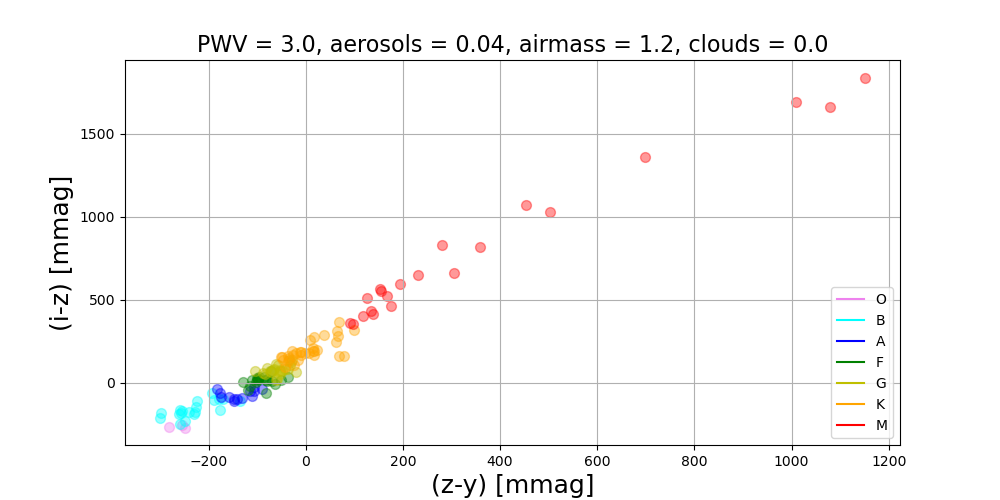

In [39]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

cy = 'i-z'
cx = 'z-y'

for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1_ref = pwv_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[spec_type][si][cy.lower()]*1000.
        
        ax.scatter(c1_ref,c2_ref,c=type_colors[spec_type],marker='o',s=50.,alpha=0.4,zorder=1)
        #ax.plot(c1_ref,c2_ref,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_title('PWV = {0}, aerosols = {1}, airmass = {2}, clouds = {3}'.format(pwv0,aero0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


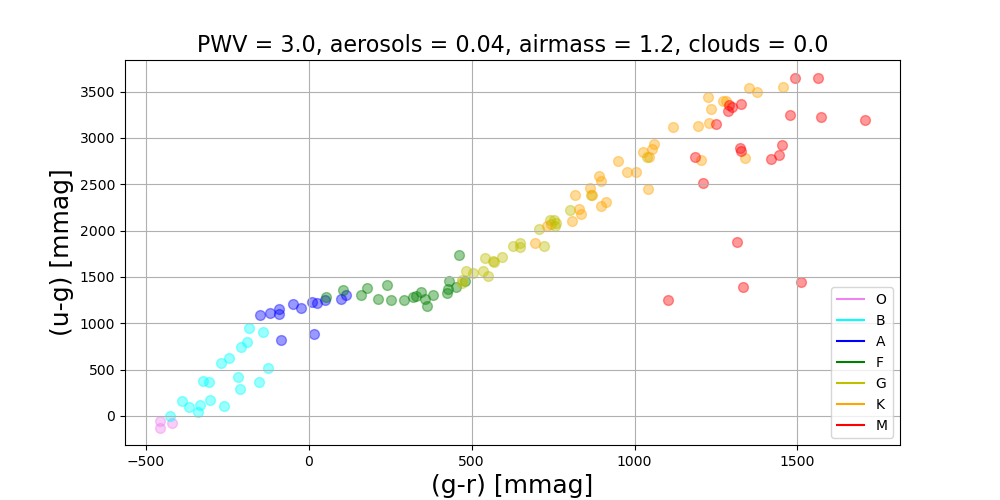

In [40]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

cy = 'u-g'
cx = 'g-r'

for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1_ref = pwv_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[spec_type][si][cy.lower()]*1000.
        
        ax.scatter(c1_ref,c2_ref,c=type_colors[spec_type],marker='o',s=50.,alpha=0.4,zorder=1)
        #ax.plot(c1_ref,c2_ref,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_title('PWV = {0}, aerosols = {1}, airmass = {2}, clouds = {3}'.format(pwv0,aero0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


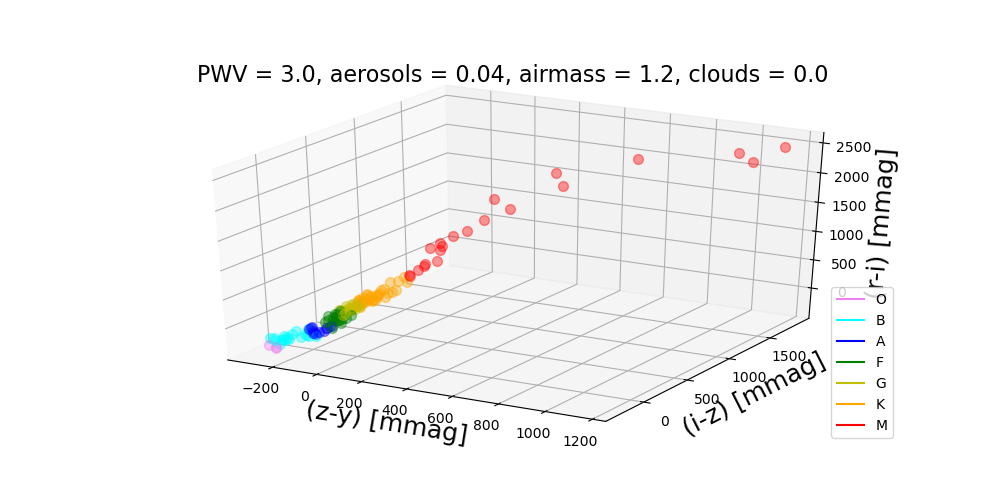

In [41]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

cz = 'r-i'
cy = 'i-z'
cx = 'z-y'

for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1_ref = pwv_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[spec_type][si][cy.lower()]*1000.
        c3_ref = pwv_color_ref_dict[spec_type][si][cz.lower()]*1000.
        
        ax.scatter(c1_ref,c2_ref,c3_ref,c=type_colors[spec_type],marker='o',s=50.,alpha=0.4,zorder=1)
        #ax.plot(c1_ref,c2_ref,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('('+cz+') [mmag]',fontsize=18)
ax.set_title('PWV = {0}, aerosols = {1}, airmass = {2}, clouds = {3}'.format(pwv0,aero0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)

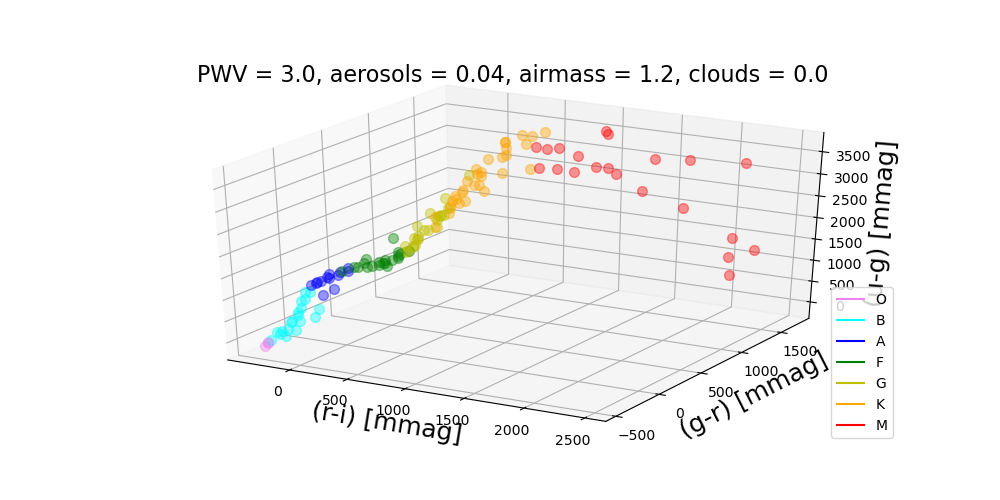

In [42]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

cz = 'u-g'
cy = 'g-r'
cx = 'r-i'

for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1_ref = pwv_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[spec_type][si][cy.lower()]*1000.
        c3_ref = pwv_color_ref_dict[spec_type][si][cz.lower()]*1000.
        
        ax.scatter(c1_ref,c2_ref,c3_ref,c=type_colors[spec_type],marker='o',s=50.,alpha=0.4,zorder=1)
        #ax.plot(c1_ref,c2_ref,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('('+cz+') [mmag]',fontsize=18)
ax.set_title('PWV = {0}, aerosols = {1}, airmass = {2}, clouds = {3}'.format(pwv0,aero0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)

# Ongoing work 

We have used the stellar types as an approach to evaluate the dependance of the color corrections with the SED of the sources. But we need to keep in mind that with LSST we won't have SEDs, but a magnitude vector, $\vec{m} = (u,g,r,i,z,Y)$, and therefore a color vector, $\vec{c}$. For this reason, we need to work on magnitude/color space. Our current work is to investigate an object clasification in color space to better determine the necessary color corrections 

If you are interested, JOIN US! 

Contact us by email or on slack: 
* Marc Moniez (marc.moniez@ijclab.in2p3.fr)
* Sylvie Dagoret-Campagne (sylvie.dagoret-campagne@ijclab.in2p3.fr)
* Martín Rodríguez Monroy (martin.rodriguez-monroy@ijclab.in2p3.fr)

